## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
"""
# 載入 Callbacks, 並將 monitor 設定監控為 Validation Accuracy
"""
from keras.callbacks import EarlyStopping
results = {}

PATIENCE = [10, 25]


for pt in PATIENCE:
    keras.backend.clear_session()
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    earlystop = EarlyStopping(monitor="Validation Accuracy", 
                          patience=PATIENCE, 
                          verbose=1
                          )
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "earlystop-%s" % (str(pt))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batc

C:\Users\user\Anaconda3\lib\site-packages\keras\callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `Validation Accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


50000/50000 [==============================] - 16s 321us/step - loss: 1.7546 - acc: 0.3916 - val_loss: 1.8349 - val_acc: 0.3674
Epoch 3/30
50000/50000 [==============================] - 16s 322us/step - loss: 1.6291 - acc: 0.4334 - val_loss: 1.7010 - val_acc: 0.4025
Epoch 4/30
50000/50000 [==============================] - 16s 319us/step - loss: 1.5524 - acc: 0.4596 - val_loss: 1.6452 - val_acc: 0.4205
Epoch 5/30
50000/50000 [==============================] - 16s 314us/step - loss: 1.4958 - acc: 0.4806 - val_loss: 1.6069 - val_acc: 0.4389
Epoch 6/30
50000/50000 [==============================] - 16s 327us/step - loss: 1.4498 - acc: 0.4963 - val_loss: 1.5771 - val_acc: 0.4473
Epoch 7/30
50000/50000 [==============================] - 16s 322us/step - loss: 1.4080 - acc: 0.5106 - val_loss: 1.5611 - val_acc: 0.4508
Epoch 8/30
50000/50000 [==============================] - 16s 320us/step - loss: 1.3710 - acc: 0.5257 - val_loss: 1.5307 - val_acc: 0.4634
Epoch 9/30
50000/50000 [==============

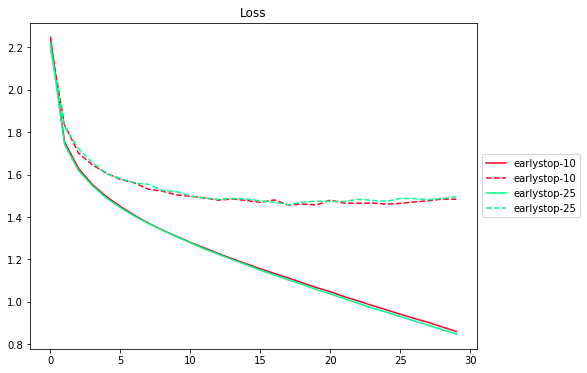

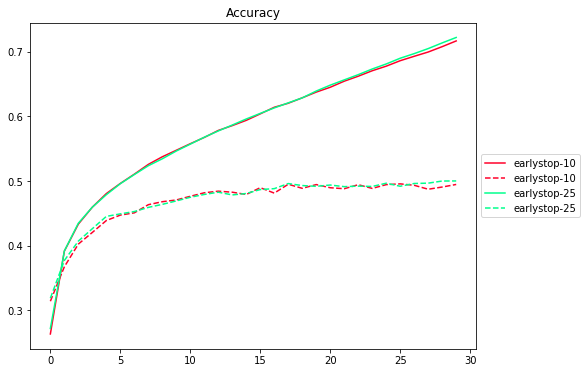

In [8]:
# 畫圖表示
import matplotlib.pyplot as plt
%matplotlib inline  

NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()